EDA for the movie data


In [1]:
import numpy as np
import pandas as pd
import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from surprise import KNNBasic
import heapq
from collections import defaultdict
from operator import itemgetter
from wordcloud import WordCloud
#from textblob import TextBlob
import string

In [2]:
dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')
dfgenome_scores = pd.read_csv('genome_scores.csv')
dfgenome_tags = pd.read_csv('genome_tags.csv')
dfimdb_data = pd.read_csv('imdb_data.csv')
dflinks = pd.read_csv('links.csv')
dfmovies = pd.read_csv('movies.csv')
dftags = pd.read_csv('tags.csv')

In [4]:
dfmovies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Overview of the Wordclouds
 This is to find out if there are more words that appear more often that might be more worthy and could mean something ?
 we will use the imdb_data to axtract if there are favourite cast crew, directors and even plot keywords
 we will start by removing some pancuations from the plot keywords and the title cast


In [102]:
dfimdb_data["title_cast"] = dfimdb_data["title_cast"].astype('str')
dfimdb_data["director"] = dfimdb_data["director"].astype('str')
dfimdb_data["plot_keywords"] = dfimdb_data["plot_keywords"].astype('str')

In [103]:
dfimdb_data["plot_keywords"] = dfimdb_data["plot_keywords"].apply(lambda x: x.replace('|',' '))
dfimdb_data["title_cast"] = dfimdb_data["title_cast"].apply(lambda x: x.replace(' ',''))
dfimdb_data["title_cast"] = dfimdb_data["title_cast"].apply(lambda x: x.replace('|',' '))
dfimdb_data["director"] = dfimdb_data["director"].apply(lambda x: x.replace(' ',''))
dfimdb_data["director"] = dfimdb_data["director"].apply(lambda x: x.replace('Seefullsummary',''))
dfimdb_data["director"] = dfimdb_data["director"].apply(lambda x: x.replace('nan',''))
dfimdb_data["title_cast"] = dfimdb_data["title_cast"].apply(lambda x: x.replace('nan',''))
dfimdb_data["plot_keywords"] = dfimdb_data["plot_keywords"].apply(lambda x: x.replace('nan',''))

In [104]:
dfimdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,81.0,"$30,000,000",toy rivalry cowboy cgi animation
1,2,RobinWilliams JonathanHyde KirstenDunst Bradle...,JonathanHensleigh,104.0,"$65,000,000",board game adventurer fight game
2,3,WalterMatthau JackLemmon SophiaLoren Ann-Margr...,MarkStevenJohnson,101.0,"$25,000,000",boat lake neighbor rivalry
3,4,WhitneyHouston AngelaBassett LorettaDevine Lel...,TerryMcMillan,124.0,"$16,000,000",black american husband wife relationship betra...
4,5,SteveMartin DianeKeaton MartinShort KimberlyWi...,AlbertHackett,106.0,"$30,000,000",fatherhood doberman dog mansion


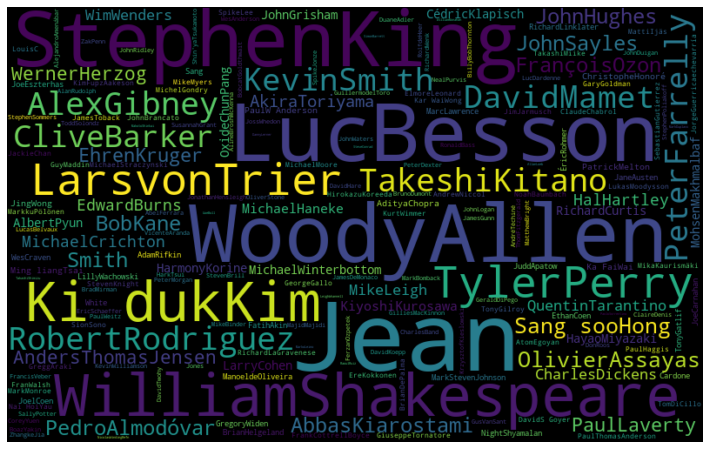

In [105]:
directors = ' '.join([text for text in dfimdb_data["director"]])

# Word cloud for the overall data checking out which words do people use more often
wordcloud = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(directors)

#ploting the word cloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

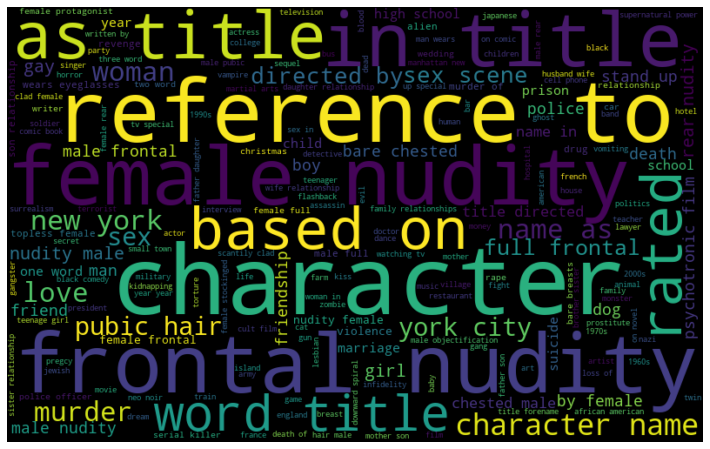

In [106]:
plot_keywords= ' '.join([text for text in dfimdb_data["plot_keywords"]])

# Word cloud for the overall data checking out which words do people use more often
wordcloud = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(plot_keywords)

#ploting the word cloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

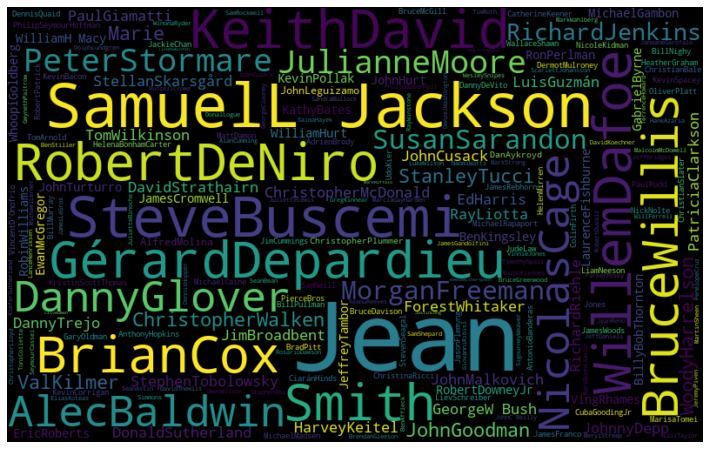

In [107]:
title_cast= ' '.join([text for text in dfimdb_data["title_cast"]])

# Word cloud for the overall data checking out which words do people use more often
wordcloud = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(title_cast)

#ploting the word cloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

from above we can see some of the famouse actors such as amuel L Jackson, Bruce Willis, Nicolas Cage, Robert Deniro, a predominant in our word cloud, so we would expect movies that those people appear on to have high ratings(to check some of the ratings from these predominat actors)

***creating gnere vs ratings data frame*** this will help us to see if there some favourite genres

In [7]:
dfgenre_ratings= pd.merge(dftrain,dfmovies, on ='movieId')

In [8]:
dfgenre_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [10]:
dfgenre_ratings['genres'] = dfgenre_ratings['genres'].apply(lambda x: x.replace('|',' '))

In [23]:
dfgenre_ratings['title'].nunique()

48151

In [26]:
genres= ' '.join([text for text in dfgenre_ratings['genres']])

# Word cloud for the overall data checking out which words do people use more often
wordcloud = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(genres)

#ploting the word cloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

MemoryError: 